# Creating a predictive model (XGBoost vs Random Forest)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
import warnings
warnings.filterwarnings('ignore')

/Users/thamxiangcong/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("/Users/thamxiangcong/Downloads/healthcare-dataset-stroke-data.csv")

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.sample(n=4000)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3077,18986,Female,45.0,0,0,No,Self-employed,Urban,88.47,29.3,never smoked,0
3488,57968,Female,11.0,0,0,No,children,Urban,107.18,27.6,Unknown,0
1726,63416,Female,16.0,0,0,No,Private,Urban,58.02,22.5,Unknown,0
779,55847,Male,19.0,0,0,No,Private,Rural,106.70,24.0,never smoked,0
243,40460,Female,68.0,1,1,Yes,Private,Urban,247.51,40.5,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2888,30627,Female,56.0,0,0,Yes,Govt_job,Urban,89.53,23.1,Unknown,0
965,5684,Male,40.0,0,0,No,Private,Urban,88.27,NaN,formerly smoked,0
448,36471,Male,65.0,0,0,Yes,Private,Urban,145.15,28.9,Unknown,0
1963,49480,Female,31.0,0,0,No,Private,Urban,106.13,22.4,never smoked,0


In [5]:
df.groupby('gender').aggregate(sum)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
gender,,,,,,,
Female,109220177,131009.64,276,113,311549.08,84203.5,141
Male,77329775,89852.36,222,163,230722.22,57611.0,108
Other,56156,26.00,0,0,143.33,22.4,0


In [6]:
df.groupby('ever_married').aggregate(sum)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
ever_married,,,,,,,
No,63458752,38679.0,53,32,169459.40,42991.1,29
Yes,123147356,182209.0,445,244,372955.23,98845.8,220


In [7]:
df.groupby('work_type').aggregate(sum)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
work_type,,,,,,,
Govt_job,23991627,33428.0,73,36,70811.31,19228.9,33
Never_worked,842037,356.0,0,0,2112.94,562.0,0
Private,108082339,133099.0,281,158,312380.77,85186.3,149
Self-employed,29116505,49305.0,144,81,92256.62,23414.2,65
children,24573600,4700.0,0,1,64852.99,13445.5,2


In [8]:
df.groupby('Residence_type').aggregate(sum)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
Residence_type,,,,,,,
Rural,91881667,107852.64,251,134,267427.34,69895.1,114
Urban,94724441,113035.36,247,142,274987.29,71941.8,135


In [9]:
df.groupby('smoking_status').aggregate(sum)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
smoking_status,,,,,,,
Unknown,55428121,46675.0,52,48,153784.78,38063.2,47
formerly smoked,32637899,48613.0,120,77,99904.18,25735.4,70
never smoked,69688304,88441.0,232,90,203499.91,55527.7,90
smokes,28851784,37159.0,94,61,85225.76,22510.6,42


In [10]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [11]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'hypertension'}>],
       [<AxesSubplot:title={'center':'heart_disease'}>,
        <AxesSubplot:title={'center':'avg_glucose_level'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'stroke'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

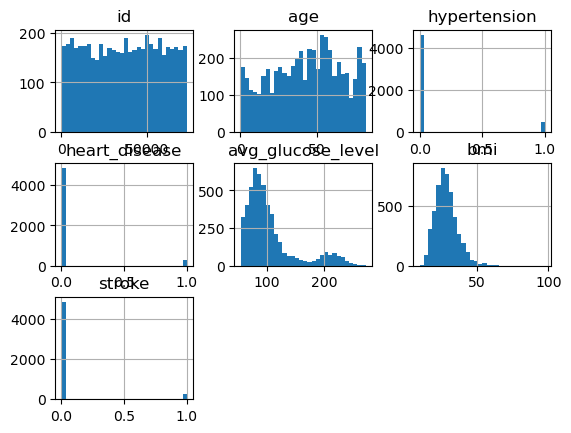

In [12]:
df.hist(bins=30)

BMI is right skewed. Let's replae NA values with median.

In [13]:
median = df.bmi.median()

In [14]:
df.bmi = df.bmi.fillna(median)

In [15]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [16]:
#Drop ID column
df = df.drop(labels='id', axis=1)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [17]:
# Mapping of strings to numerical values [25 objects]
#1 
df['gender'] = df['gender'].map({'Male':1, 'Female':2, 'Other':3})
#2
df['ever_married'] = df['ever_married'].map({'Yes':1, 'No':0})
#3
df['work_type'] = df['work_type'].map({'Private':1, 'Self-employed':2, 'Govt_job':3, 'children':4, 'Never_worked': 5})
#4
df['Residence_type'] = df['Residence_type'].map({'Urban':1, 'Rural':2})
#5
df['smoking_status'] = df['smoking_status'].map({'smokes':1, 'formerly smoked':2, 'never smoked':3, 'Unknown':4})

In [18]:
df.sample(n=2000)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
598,1,15.0,0,0,0,4,2,205.50,24.2,3,0
3505,2,77.0,0,0,1,2,1,151.23,24.9,3,0
2841,2,57.0,0,0,1,1,2,93.85,29.1,3,0
3437,1,32.0,0,0,1,1,2,82.68,29.2,3,0
85,1,54.0,0,0,1,1,2,96.97,29.1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2936,1,16.0,0,0,0,1,2,99.49,22.0,4,0
4322,1,6.0,0,0,0,4,1,91.89,22.4,4,0
348,2,25.0,0,0,0,1,2,66.30,27.2,3,0
1210,2,58.0,0,0,1,1,1,80.92,19.4,4,0


In [19]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [20]:
X = df.drop('stroke',axis = 1)
y = df["stroke"]

In [21]:
X

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,67.0,0,1,1,1,1,228.69,36.6,2
1,2,61.0,0,0,1,2,2,202.21,28.1,3
2,1,80.0,0,1,1,1,2,105.92,32.5,3
3,2,49.0,0,0,1,1,1,171.23,34.4,1
4,2,79.0,1,0,1,2,2,174.12,24.0,3
...,...,...,...,...,...,...,...,...,...,...
5105,2,80.0,1,0,1,1,1,83.75,28.1,3
5106,2,81.0,0,0,1,2,1,125.20,40.0,3
5107,2,35.0,0,0,1,2,2,82.99,30.6,3
5108,1,51.0,0,0,1,1,2,166.29,25.6,2


In [22]:
y

0       1
1       1
2       1
3       1
4       1
       ..
5105    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 5110, dtype: int64

In [23]:
# Split data
X_train, X_, y_train, y_ = train_test_split(X, y, test_size = 0.4, random_state = 49)
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size = 0.5, random_state = 49)

## XGBoost

In [24]:
xgb = XGBClassifier ()

In [25]:
param = {
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'max_depth': [2,4,6,8],
    'reg_lamda': [0.001,0.01,0.1],
    'reg_alpha': [0.001,0.01,0.1],
}

In [26]:
clf = GridSearchCV(xgb, param_grid = param)

In [27]:
clf = clf.fit(X_train, y_train)

[15:57:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:57:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:57:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "reg_l

In [28]:
clf.best_params_

{'learning_rate': 0.001,
 'max_depth': 2,
 'reg_alpha': 0.001,
 'reg_lamda': 0.001}

In [29]:
best_params = clf.best_params_

In [30]:
xgb = XGBClassifier(**best_params)

In [31]:
xgb.fit(X_train, y_train)

[15:58:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:58:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.001, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.001, reg_lambda=1, reg_lamda=0.001,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [32]:
# Calculate the cost function of baseline performance using RMSE
yhat = xgb.predict(X_train)
mean_squared_error(y_train, yhat, squared = False)

0.2159642888021867

In [33]:
# Calculate the cost function of J_cv using RMSE
yhat = xgb.predict(X_cv)
mean_squared_error(y_cv, yhat, squared = False)

0.213991970879243

In [34]:
# Calculate the cost function of J_test using RMSE
yhat = xgb.predict(X_test)
mean_squared_error(y_test, yhat, squared = False)

0.22729585365347654

Noted that XGBoost provides low bias and low variance model.

## Random Forest

In [35]:
rfc = RandomForestClassifier(max_depth = 2, random_state=42)

In [36]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=42)

In [37]:
# Calculate the cost function of baseline performance using RMSE
yhat = rfc.predict(X_train)
mean_squared_error(y_train, yhat, squared = False)

0.2159642888021867

In [40]:
# Calculate the cost function of J_cv performance using RMSE
yhat = rfc.predict(X_cv)
mean_squared_error(y_cv, yhat, squared = False)

0.213991970879243

In [41]:
# Calculate the cost function of J_test performance using RMSE
yhat = rfc.predict(X_test)
mean_squared_error(y_test, yhat, squared = False)

0.22729585365347654

Noted that Random Forest provides low bias and low variance model. Also noted that both have the exact RMSE. Both are good models to predict stroke.